
# Multiclass Classification

Building a neural network to solve a multiclass classification exercise using the PyTorch framework.<br>
Classification is one of the basic machine learning exercises. A trained model aims to predict the class of an input unit with high accuracy. <br>
This neural network uses supervised learning, meaning that the input datasets also provide target labels to train the model with. <br>
<br>
This Notebook has been generated automatically using the JupyterLab extension ***MLProvCodeGen***.
<br>

Original Source Code and inspiration from this article https://janakiev.com/blog/pytorch-iris/ <br>
Original author: N. Janakiev https://github.com/njanakiev Twitter: https://twitter.com/njanakiev
        

### Installs
Install required packages before running

In [1]:
#pip install numpy===1.22.2 pandas===1.3.3 matplotlib===3.5.1 sklearn==0.0 torch===1.8.0 tqdm===4.60.0 ipywidgets===7.6.5 pytorch-model-summary===0.1.2 ipython===7.31.1 gputil===1.4.0 psutil===5.9.0 py-cpuinfo===8.0.0 --user
#torch currently not supported with python 3.10, downgrading to python 3.9.7 possibly required
#!pip install prov 2.0.0

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import GPUtil
import psutil
import cpuinfo
import platform
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from tqdm import trange
from datetime import date
import time
from pytorch_model_summary import hierarchical_summary
import json
import ipywidgets as widgets
import webbrowser
import IPython
from IPython.display import display

plt.style.use('ggplot')

from prov.model import ProvDocument
import prov as prov
import datetime

### Provenance Data 

In [3]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

#namespaces
d1 = ProvDocument()
d1.set_default_namespace('provenanceexample.org')

In [4]:
#set_experiment_info()
d1.add_namespace('experimentinfo', 'experimentinfo.org')
e1 = d1.entity('experiment_info', (
    ('experimentinfo:author', 'Tarek Al Mustafa'),
    ('experimentinfo:email', 'tarek.almustafa@uni-jena.de'),
    ('experimentinfo:title', 'Multiclass Classification'),
    ('experimentinfo:creation_date', str(date.today())),
    ('experimentinfo:task_type', 'MulticlassClassification'),
))
#activity
a1 = d1.activity('set_experiment_info()', datetime.datetime.now(), None)

d1.wasGeneratedBy(e1, a1, None, {'ex:fct': 'set'})
d1.wasAssociatedWith('experiment_info', 'Tarek Al Mustafa', None, None)
d1.agent('Tarek Al Mustafa')               

<ProvAgent: Tarek Al Mustafa>

In [5]:
#set_hardware_info()
uname = platform.uname()
sysInfo = str(uname.system +' '+ uname.release +' Version: '+ uname.version +' Machine: '+ uname.machine)
    
svmem = psutil.virtual_memory()

GPUs = GPUtil.getGPUs()
gpuList = []
for gpu in GPUs:
    gpu_id = gpu.id
    gpu_name = gpu.name
    gpuList.append((gpu_id , gpu_name))

        
d1.add_namespace('hardwareinfo', 'hardwareinfo.org')
e2 = d1.entity('hardware_info', (
    ('hardwareinfo:Python Version', cpuinfo.get_cpu_info()['python_version']),
    ('hardwareinfo:CPU', cpuinfo.get_cpu_info()['brand_raw']),
    ('hardwareinfo:RAM',  get_size(svmem.total)),
    ('hardwareinfo:Operating System', sysInfo),
    ('hardwareinfo:GPUs', str(gpuList)),
))
#activity
a2 = d1.activity('set_hardware_info()', datetime.datetime.now(), None)
a3 = d1.activity('platform.uname()')
a4 = d1.activity('cpuinfo.get_cpu_info()')
a5 = d1.activity('svmem.total')
a6 = d1.activity('get_size(svmem.total)')
a7 = d1.activity('GPUtil.getGPUs()')
d1.wasGeneratedBy(e2, a2, None, {'experimentinfo:fct': 'set'})
d1.wasInformedBy(a2, a3)
d1.wasInformedBy(a2, a4)
d1.wasInformedBy(a2, a5)
d1.wasInformedBy(a5, a6)
d1.wasInformedBy(a2, a7)

<ProvCommunication: (set_hardware_info(), GPUtil.getGPUs())>

In [6]:
#set_packages
cpuInfo_version = !pip list | grep -i py-cpuinfo
pytorch_model_summary_version = !pip list | grep -i pytorch-model-summary

d1.add_namespace('packages', 'packages.org')

e3 = d1.entity('packages', (
    ('packages:numpy', np.__version__),
    ('packages:pandas', pd.__version__),
    ('packages:matplotlib',  matplotlib.__version__),
    ('packages:sklearn', sklearn.__version__),
    ('packages:torch', torch.__version__),
    ('packages:tqdm', tqdm.__version__),
    ('packages:ipywidgets', widgets.__version__),
    ('packages:pytorch-model-summary', pytorch_model_summary_version[0]),
    ('packages:ipython', IPython.__version__),
    ('packages:gputil', GPUtil.__version__),
    ('packages:psutil', psutil.__version__),
    ('packages:py-cpuinfo', cpuInfo_version[0]),
    ('packages:prov', prov.__version__),  
))
a8 = d1.activity('set_packages()', datetime.datetime.now())
a9 = d1.activity('{package_name}.__version__')
a10 = d1.activity('!pip list | grep -i py-cpuinfo')
a11 = d1.activity('!pip list | grep -i pytorch-model-summary')
d1.wasGeneratedBy(e3, a8, None, {'packages:fct': 'set'})
d1.wasInformedBy(a8,a9)
d1.wasInformedBy(a8,a10)
d1.wasInformedBy(a8,a11)

<ProvCommunication: (set_packages(), !pip list | grep -i pytorch-model-summary)>

### Data Ingestion

In [7]:
#Data Ingestion
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
output_dim = len(names)
feature_names = iris['feature_names']

In [8]:
#set_data_ingestion
d1.add_namespace('dataingestion', 'dataingestion.org')

e4 = d1.entity('data_ingestion', (
    ('dataingestion:dataset_id', 'Iris'),
    ('dataingestion:output_dimensions', output_dim),
    ('dataingestion:samples_total',  len(X)),
    ('dataingestion:feature_dimensions', len(feature_names)),  
))
a12 = d1.activity('set_data_ingestion()', datetime.datetime.now())
d1.wasGeneratedBy(e4, a12, None, {'packages:fct': 'set'})


<ProvGeneration: (data_ingestion, set_data_ingestion())>

### Data preparation

In [9]:
#Data Preperation
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
#set_data_preparation
d1.add_namespace('datapreparation', 'datapreparation.org')

e5 = d1.entity('data_preparation', (
    ('datapreparation:number_operations', 1),
    ('datapreparation:transformation', 'sklearn.preprocessing.StandardScaler'),
    ('datapreparation:transformation_method', 'Standardscaler.fit_transform'), 
))
a13 = d1.activity('set_data_preparation()', datetime.datetime.now())
d1.wasGeneratedBy(e5, a13, None, {'packages:fct': 'set'})

<ProvGeneration: (data_preparation, set_data_preparation())>

### Data Segregation

In [11]:
# Data Segregation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [12]:
#set_data_segregation

d1.add_namespace('datasegregation', 'datasegregation.org')

e6 = d1.entity('data_segregation', (
    ('datasegregation:segregation_method', 'sklearn.model_selection.train_test_split'),
    ('datasegregation:test_size', 0.2),
    ('datasegregation:train_size', 1-0.2), 
    ('datasegregation:random_state', 2), 
))
a14 = d1.activity('set_data_segregation()', datetime.datetime.now())
d1.wasGeneratedBy(e6, a14, None, {'packages:fct': 'set'})

<ProvGeneration: (data_segregation, set_data_segregation())>

### Data Visualization

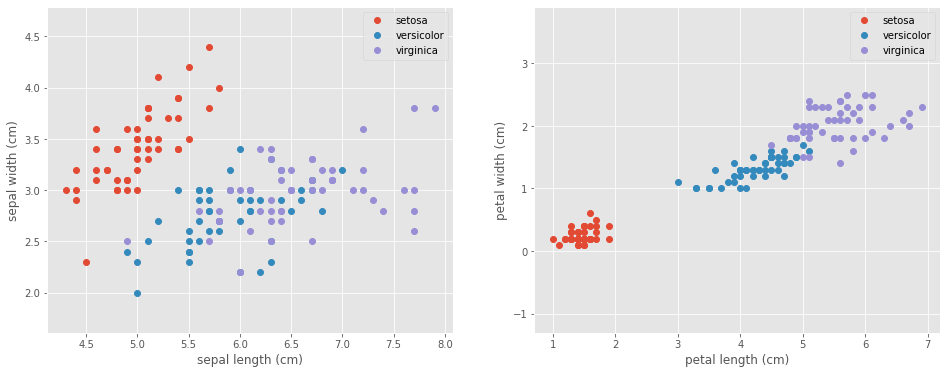

In [13]:
#Data Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();


### Model

In [14]:
#Use GPU?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

neuron_number = 50

#Configure Neural Network Models
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters())
loss_fn   = nn.CrossEntropyLoss()

try:
    lr
except NameError:
    default = 1
    lr = None 
else:
    default = 0

model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [15]:
#set_model_parameters

d1.add_namespace('modelparameters', 'modelparameters.org')

e7 = d1.entity('model_parameters', (
    ('modelparameters:gpu_enable', 1),
    ('modelparameters:modelParameters', str(model)),
    ('modelparameters:neuron_number', neuron_number), 
    ('modelparameters:loss_function', 'nn.CrossEntropyLoss()'), 
    ('modelparameters:optimizer', 'torch.optim.Adam('), 
    ('modelparameters:optimizer_default_learning_rate', default), 
    ('modelparameters:optimizer_learning_rate', lr), 
    ('modelparameters:activation_function', 'F.softmax(self.layer3(x), dim=1)'), 
))
a15 = d1.activity('set_model_parameters()', datetime.datetime.now())
d1.wasGeneratedBy(e7, a15, None, {'packages:fct': 'set'})

<ProvGeneration: (model_parameters, set_model_parameters())>

### Training

In [16]:
#Model Training
EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1074.30it/s]


In [17]:
#set_training

d1.add_namespace('training', 'training.org')

e8 = d1.entity('training', (
    ('training:epochs', EPOCHS),
    ('training:numberOfParameters', hierarchical_summary(model, print_summary = False)[1]),
))
a16 = d1.activity('set_training()', datetime.datetime.now())
a17 = d1.activity('hierarchical_summary(model, print_summary = False)[1]')
d1.wasGeneratedBy(e8, a16, None, {'packages:fct': 'set'})
d1.wasInformedBy(a16, a17)

<ProvCommunication: (set_training(), hierarchical_summary(model, print_summary = False)[1])>

### Evaluation

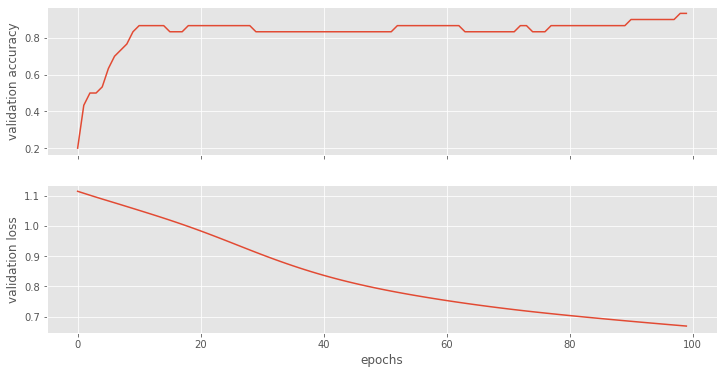

In [18]:
#Plot Accuracy and Loss from Training
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

### Confusion Matrix

In [19]:
confusionMatrix = confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
confusionMatrix

array([[13,  1,  0],
       [ 0,  7,  1],
       [ 0,  0,  8]], dtype=int64)

### F1 Score

In [20]:
F1 = f1_score(y_test, torch.argmax(y_pred, dim=1), average=None)
F1

array([0.96296296, 0.875     , 0.94117647])

### Mean Absolute Error & Mean Squared Error

In [21]:
MAE = mean_absolute_error(y_test, torch.argmax(y_pred, dim=1), multioutput='uniform_average')
MSE = mean_squared_error(y_test, torch.argmax(y_pred, dim=1), multioutput='uniform_average')
print(MAE)
print(MSE)

0.06666666666666667
0.06666666666666667


### ROC

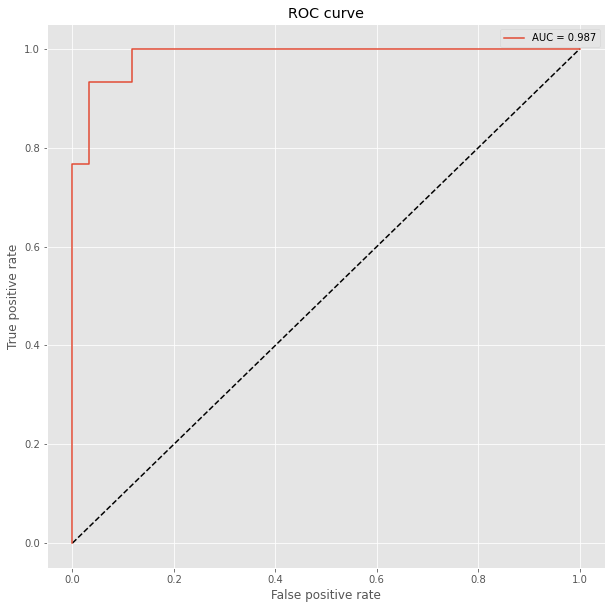

In [22]:
#ROC Curve 
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
AUC = '{:.5f}'.format(auc(fpr, tpr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [23]:
#set_evaluation

d1.add_namespace('evaluation', 'evaluation.org')

e9 = d1.entity('evaluation', (
    ('evaluation:Accuracy', accuracy_list[(len(accuracy_list)-1)]),
    ('evaluation:Loss', loss_list[(len(loss_list)-1)]),
    ('evaluation:Confusion Matrix', str(confusionMatrix)),
    ('evaluation:AUC', float(AUC)),
    ('evaluation:F1 Score', str(F1)),
    ('evaluation:Mean Absolute Error', MAE),
    ('evaluation:Mean Squared Error', MSE),
))
a17 = d1.activity('set_evaluation()', datetime.datetime.now())
d1.wasGeneratedBy(e9, a17, None, {'packages:fct': 'set'})

<ProvGeneration: (evaluation, set_evaluation())>

### Generate Provenance Data

{
  "prefix": {
    "experimentinfo": "experimentinfo.org",
    "hardwareinfo": "hardwareinfo.org",
    "packages": "packages.org",
    "dataingestion": "dataingestion.org",
    "datapreparation": "datapreparation.org",
    "datasegregation": "datasegregation.org",
    "modelparameters": "modelparameters.org",
    "training": "training.org",
    "evaluation": "evaluation.org",
    "default": "provenanceexample.org"
  },
  "entity": {
    "experiment_info": {
      "experimentinfo:author": "Tarek Al Mustafa",
      "experimentinfo:email": "tarek.almustafa@uni-jena.de",
      "experimentinfo:title": "Multiclass Classification",
      "experimentinfo:creation_date": "2022-03-29",
      "experimentinfo:task_type": "MulticlassClassification"
    },
    "hardware_info": {
      "hardwareinfo:Python Version": "3.9.7.final.0 (64 bit)",
      "hardwareinfo:CPU": "AMD Ryzen 7 3700X 8-Core Processor",
      "hardwareinfo:RAM": "15.95GB",
      "hardwareinfo:Operating System": "Windows 10 Version:

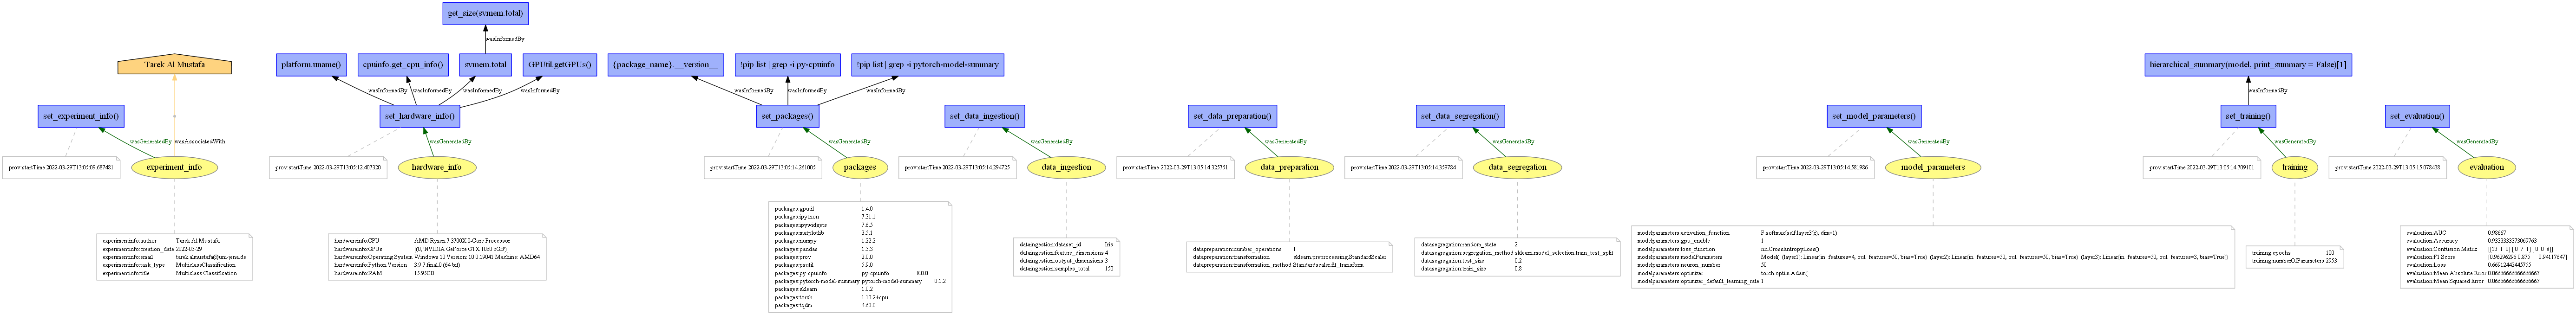

In [24]:
print(d1.serialize(indent=2))
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# visualize the graph
from prov.dot import prov_to_dot

dot = prov_to_dot(d1)
dot.write_png('provenanceData.png')
from IPython.display import Image
dot.write_pdf('provenanceData.pdf')
Image('provenanceData.png')


### Write Provenance Data

In [25]:
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceName = ('Provenance_MulticlassClassification_' + timestring + '.json')

with open('../GeneratedProvenanceData/'+ProvenanceName, 'w') as prov_file:
    prov_file.write(d1.serialize(indent=2))

### Show Provenance Data

In [26]:
provenance_open = widgets.Button(description = 'Open Provenance Data File')
display(provenance_open)

def on_button_clicked(b):
    provenance_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceName)

provenance_open.on_click(on_button_clicked)

Button(description='Open Provenance Data File', style=ButtonStyle())